In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
# Import libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import transformers
from transformers import AutoTokenizer, AutoModel, BertTokenizerFast
device = 'cuda'

In [29]:
# Import datasets
train = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/turkish-offensive-lang-dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/turkish-offensive-lang-dataset/test.csv')
valid = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/turkish-offensive-lang-dataset/valid.csv')

In [30]:
frames = [train, test, valid]
df = pd.concat(frames)
df

,id,text,label
0,26418.0,Gerçekten sizin hikayelerinizi izleyerek mi ye...,0
1,14473.0,@USER Çoook çok bi baklava bi sen zaten,0
2,16107.0,"1) Sn. DÜKEL; Atatürk'ün, Karma E. M. ile başl...",0
3,45908.0,Konfederasyonumuzun Aile ve Sosyal Politikalar...,0
4,12878.0,Hakemler tarih yazıyorlar / 9 kişiye karşı 3-2...,1
...,...,...,...
1751,39603.0,"Bu ödül sunan kızı kim giydirdiyse, kızın en b...",0
1752,26675.0,Bunu sana beddua olarak etmiyorum bunlar ilerd...,0
1753,17172.0,CHP'liler sandıkları bırakmıyor üstüne oturmuş...,1
1754,42884.0,karanlığın içinde yalnız kalsam ne oluuuuurr,0


In [31]:
# Preprocess text
def filter(text):
    final_text = ''
    for word in text.split():
        if word.startswith('@'):
            continue
        elif word[-3:] in ['com', 'org']:
            continue
        elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
            continue
        else:
            final_text += word+' '
    return final_text

df['text'] = df['text'].apply(filter)
df

,id,text,label
0,26418.0,Gerçekten sizin hikayelerinizi izleyerek mi ye...,0
1,14473.0,Çoook çok bi baklava bi sen zaten,0
2,16107.0,"1) Sn. DÜKEL; Atatürk'ün, Karma E. M. ile başl...",0
3,45908.0,Konfederasyonumuzun Aile ve Sosyal Politikalar...,0
4,12878.0,Hakemler tarih yazıyorlar / 9 kişiye karşı 3-2...,1
...,...,...,...
1751,39603.0,"Bu ödül sunan kızı kim giydirdiyse, kızın en b...",0
1752,26675.0,Bunu sana beddua olarak etmiyorum bunlar ilerd...,0
1753,17172.0,CHP'liler sandıkları bırakmıyor üstüne oturmuş...,1
1754,42884.0,karanlığın içinde yalnız kalsam ne oluuuuurr,0


<Axes: >

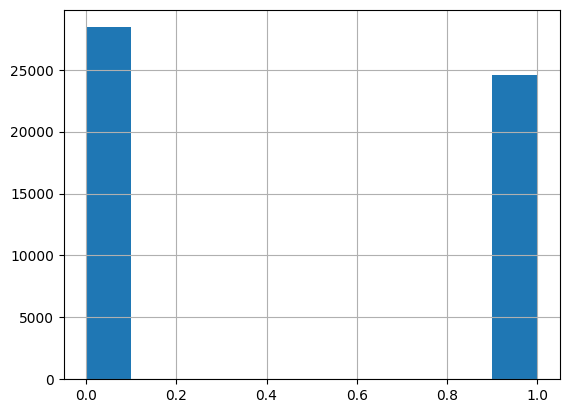

In [32]:
# Plot the histogram of the labels
df.label.hist()

In [33]:
# Shuffle dataset
from sklearn.utils import shuffle
df = shuffle(df)

In [34]:
# Split data into train, test, valid
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
																	random_state = 2021,
																	test_size = 0.2,
																	stratify = df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
																random_state = 2021,
																test_size = 0.5,
																stratify = temp_labels)

In [35]:
# Import pretrained tokenizer and model from https://huggingface.co/YSKartal/bert-base-turkish-cased-turkish_offensive_trained_model
tokenizer = AutoTokenizer.from_pretrained("YSKartal/bert-base-turkish-cased-turkish_offensive_trained_model")
bert = AutoModel.from_pretrained("YSKartal/bert-base-turkish-cased-turkish_offensive_trained_model",return_dict=False, from_tf=True)

All TF 2.0 model weights were used when initializing BertModel.

All the weights of BertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.


In [36]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [37]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [38]:
#### Create DataLoaders
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Freeze Model parameters and Define Model Architecture

In [39]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [40]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 3 (Output layer)
      self.fc3 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc3(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [41]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [42]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 0.0001)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Find Class Weights

In [43]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.93228388 1.07832367]


In [44]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 5

### Fine Tuning

In [45]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [46]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [47]:
# Define Early Stopping Function
def early_stopping(train_loss, validation_loss, min_delta, tolerance):

    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

### Start Training

In [48]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train the model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/turkish_offensive_language.pt')
    
    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    # Early stopping
    if early_stopping(train_loss, valid_loss, min_delta=10, tolerance = 20):
      print("We are at epoch:", epoch)
      break


 Epoch 1 / 5
  Batch    50  of  1,326.
  Batch   100  of  1,326.
  Batch   150  of  1,326.
  Batch   200  of  1,326.
  Batch   250  of  1,326.
  Batch   300  of  1,326.
  Batch   350  of  1,326.
  Batch   400  of  1,326.
  Batch   450  of  1,326.
  Batch   500  of  1,326.
  Batch   550  of  1,326.
  Batch   600  of  1,326.
  Batch   650  of  1,326.
  Batch   700  of  1,326.
  Batch   750  of  1,326.
  Batch   800  of  1,326.
  Batch   850  of  1,326.
  Batch   900  of  1,326.
  Batch   950  of  1,326.
  Batch 1,000  of  1,326.
  Batch 1,050  of  1,326.
  Batch 1,100  of  1,326.
  Batch 1,150  of  1,326.
  Batch 1,200  of  1,326.
  Batch 1,250  of  1,326.
  Batch 1,300  of  1,326.

Evaluating...
  Batch    50  of    166.
  Batch   100  of    166.
  Batch   150  of    166.

Training Loss: 0.098
Validation Loss: 0.079

 Epoch 2 / 5
  Batch    50  of  1,326.
  Batch   100  of  1,326.
  Batch   150  of  1,326.
  Batch   200  of  1,326.
  Batch   250  of  1,326.
  Batch   300  of  1,326.
  

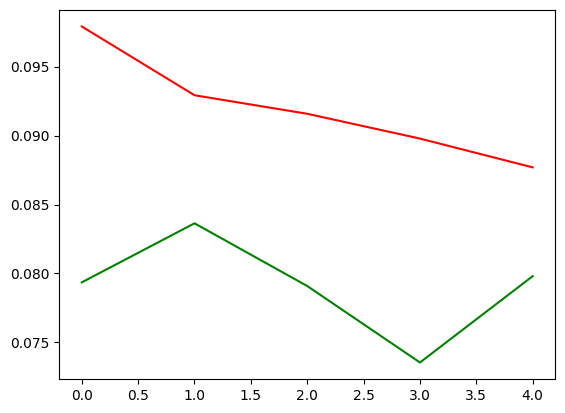

In [49]:
import matplotlib.pyplot as plt

plt.plot(train_losses, color='r')
plt.plot(valid_losses, color='g')